<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/milestone_project_1_food_vision_big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Check the GPU

/bin/bash: line 1: nvidia-smi: command not found


In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-1bef766a-70c0-56b7-58a1-42bc94e9c4bb)


## Get helper functions

In past modules,  we've created a bunch of helper functions to do small tasks required for our notebooks.

Rather then rewrite all of these, we can import a scrip and load them in form there.

The script we've got available can be found on GitHub.

In [2]:
# Download helper functions script

!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-05-26 21:16:47--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2024-05-26 21:16:48 (12.3 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
# Import series of helper fucntions
from helper_functions import create_tensorboard_callback, \
  plot_loss_curves, \
  compare_historys, \
  unzip_data, \
  walk_through_dir

## Use TensorFlow dataset to download dataset

 If you want to get an overview od TensorFlow Datasets (TFDS), read the guide: https://tensorflow.org/datasets/overview

In [48]:
# Get TensorFlow datasets

import tensorflow_datasets as tfds



In [6]:
# List all available datasets

datasets_list = tfds.list_builders() # get all available dtasets in TFDS

print("food101" in datasets_list) # is our target dataset in the list of TFDS datasets?

True


In [49]:
# Load in the dta (takes 5-6 minutes in Google colab)

(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True, # data gets returned in tuple format (data, label)
                                             with_info=True) # include dataset metadata

In [50]:
# Features of Food101 from TFDS

ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [52]:
# Get the class names

class_names = ds_info.features["label"].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the Food101 dta from TensorFlow Datasets

To become one with our data, we wabt to find:

* Class names
* The shape of our input data (image tensors)
* The datatype of our input data (floats)
* What the labels look like (e.g. are they one-hot encoding or are they label encoded)
* Do the labels match up with the class names?

In [53]:
# Take one sample of the train data

train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [54]:
# What does one sample of our trainig dat look like?

train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [55]:
# Output infor about our training sample

for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image datatype: {image.dtype}
  Target class from Food101 (str form): {class_names[label.numpy()]}
  Target class from Food101 (tensor form): {label.numpy()}
  Class name: {class_names[label.numpy()]}
  """)



  Image shape: (384, 512, 3)
  Image datatype: <dtype: 'uint8'>
  Target class from Food101 (str form): huevos_rancheros
  Target class from Food101 (tensor form): 56
  Class name: huevos_rancheros
  


In [56]:
# What does our image tensor from TDFS's Food1010 look like?

image

<tf.Tensor: shape=(384, 512, 3), dtype=uint8, numpy=
array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [144,  81, 102],
        [142,  78, 102],
        [139,  75,  99]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [159,  96, 115],
        [154,  89, 111],
        [146,  83, 104]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [162,  98, 114],
        [162,  95, 113],
        [157,  93, 110]],

       ...,

       [[ 75,  32,  16],
        [ 77,  34,  17],
        [ 78,  35,  19],
        ...,
        [ 99,  31,  20],
        [104,  32,  20],
        [106,  34,  20]],

       [[ 81,  34,  18],
        [ 81,  34,  16],
        [ 82,  35,  19],
        ...,
        [102,  33,  26],
        [104,  36,  27],
        [109,  39,  31]],

       [[ 79,  30,  13],
        [ 80,  31,  14],
        [ 81,  32,  15],
        ...,
        [113,  46,  4

In [57]:
import tensorflow as tf

# What are the min and the max values of our image tensor?

tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot a image from TensroFlow dataset

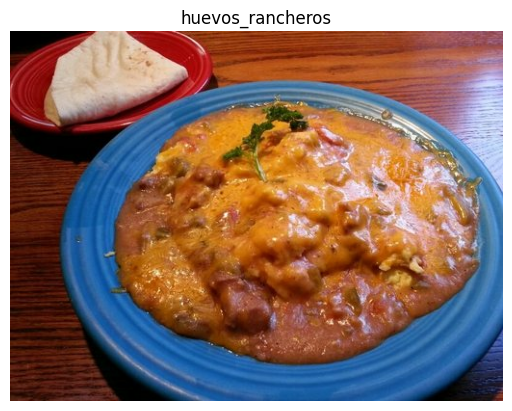

In [58]:
# Plot asn image tensor

import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add tittle to image to verify the label is associated
plt.axis(False);

## Create preprocesing functions for our data

Neural network perform best when data is in a certain way (e.g. batched, normalized, etc)

However, not all data (including dta from TenroFlow dataset ) comes like this.

So in order to get it ready for a neural netowrk, you'll often have to write preprocessing funcitions an map it to you data.

What we know about our data:

* In `uint8` datatype
* Comprised of all different size tensor (differente size images)
* Not scaled (the pixel values are between 0 & 255)

What we know models like:

* Data in `float32` dtype (or for mixed precision `float16` and `float32`)
* For batches, TensorFlow ikes all of the tensors within a batch to be of the same size
* Scaled (values between 0 & 1) also called normalized tensord generally perform better

With this points in  mind, we've got a few things we can tackle with a preprocessing function.

Since we're going to be using a EfficientNetBX pretrained model from tf.keras. applications we don't need to reecale our data (these arcjitectures have rescaling built-in).

Thie means our functions needs to:

1. Reshape all images to all the same size
2. Convert the dtype of our image from `uint8` to `float32`

In [59]:
# Make a function for preprocessing images

def preprocess_img(image, label, img_shape=224):
  """
  Converts image datatype from 'uint8' to 'float32' and reshapes image to
  [img_shape, img_shape, color_channels]
  """
  image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
  #image = image/255. # scale image values to between 0 & 1 (not required with EfficientNetBX models from tf.keras.applications)
  return tf.cast(image, tf.float32), label # return (float32_image, label) tuple

In [61]:
# Preprocesing a single sample image and check the outputs

preprocessed_img = preprocess_img(image, label)[0]

print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}")

Image before preprocessing:
 [[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  81 102]
  [142  78 102]
  [139  75  99]]

 [[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [159  96 115]
  [154  89 111]
  [146  83 104]]]...,
Shape: (384, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.23973   91.24997  110.18368 ]
  [150.2857    86.622444 107.239784]
  [144.57637   80.47435  103.6325  ]]

 [[  0.         0.         0.      ]
  [  0.         0.         0.      ]
  [  0.         0.         0.      ]
  ...
  [157.85226   91.70941  105.097206]
  [164.45404   97.72448  114.3112  ]
  [159.09677   93.16319  110.545815]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>


## Batch e prepare datasets

We're going to make our data input pipeline run on the GPU really fast.


For more resources on this, I'd highly recommend the following:
https://www.tensorflow.org/guide/data_performance

In [62]:
# Map preprocessing function to training data (and paralellize)

train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data

test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(tf.data.AUTOTUNE)

In [63]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

> "Hey, TensroFlow, map this preprocessing function (`preprocess_image`) across our trainig dataset, then shuffle a number of elements, then batch our elements and finally make sure you prepare new batches (prefetch) whilst the model is looking through (findind patterns) the current batch."

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains:

* Tensorboard callback to log training results
* ModelCheckpoint callback to sae our model's progress after feature extraction


In [64]:
# Create tensorboard callback (imported from helperfunctions.py)
from helper_functions import create_tensorboard_callback

checkpoint_path = "model_checkpoints/cp.ckpt"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

## Setup mixed precision training

First and foremost, for a deeper understang of mixed precision trainig, check out the TensorFlow guide for mixed precision:

https://www.tensorflow.org/guide/miced_precision

Mixed precision utilizes a combination of float32 and float16 dta types to speed up model performnace.

In [65]:
 # Turn on mixed precision training

from tensorflow.keras import mixed_precision

In [66]:
mixed_precision.global_policy()

<Policy "mixed_float16">

## Build feature extraction model

In [67]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

input_shape = (224, 224, 3)

# Turn on mixed precision training
mixed_precision.set_global_policy(policy="mixed_float16") # set global data policy to mixed precision

# download base model and freeze underlayng layers
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create a functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# add in data augmentation Sequential model as a layer
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
x = layers.Dense(len(class_names))(x)

# Mixed precisions required ouput layer have dtype=tf.float32
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [70]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [72]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling_lay  (None, 1280)              0         
 er (GlobalAveragePooling2D                                      
 )                                                               
                                                                 
 dense_2 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                        

## Checking layers dtype policies (are we using mixed precsion?)

In [73]:
#Check the dtype_policy attributes of layers in our model

for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling_layer True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


Going through the above we see:

* `layer. name`: the human readable name of the layer
* `layer. trainable`: is the layer trainable or not? (if `False`, teh weights are frozen)
* `layer. dtype`: the datatype of the layer
* `layer. dtype_policy`: the datatype policy of the layer

In [74]:
# Check tyep_polcy attributes of layers in teh base model

for layer in model.layers[1].layers: # Check the alyers of the base model
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_4 False float32 <Policy "float32">
rescaling_5 False float32 <Policy "mixed_float16">
normalization_3 False float32 <Policy "mixed_float16">
rescaling_6 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

## Fite the feature extarction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:

1. Build a feature extraction model (train a couple output layers with base layers frozen)
3. Fien-tune some of the frozen layers

In [75]:
# Fit the feature extraction model with callbacks

history_101_food_classes_feature_extract = model.fit(train_data,
                                                    epochs=3,
                                                    steps_per_epoch=len(train_data),
                                                    validation_data=test_data,
                                                    validation_steps=int(0.15 * len(test_data)),
                                                    callbacks=[create_tensorboard_callback(
                                                                  "training_logs",
                                                                  "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint,
                                                              ]
                                                    )


Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20240526-234850
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7203 - accuracy: 0.5814

2368/2368 [==============================] - 102s 40ms/step - loss: 1.7203 - accuracy: 0.5814 - val_loss: 1.1333 - val_accuracy: 0.6909
Epoch 2/3
2368/2368 [==============================] - ETA: 0s - loss: 1.1987 - accuracy: 0.6902

2368/2368 [==============================] - 95s 40ms/step - loss: 1.1987 - accuracy: 0.6902 - val_loss: 1.0339 - val_accuracy: 0.7174
Epoch 3/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.0539 - accuracy: 0.7237

2368/2368 [==============================] - 94s 40ms/step - loss: 1.0539 - accuracy: 0.7237 - val_loss: 1.0020 - val_accuracy: 0.7278


In [76]:
results_feature_extract_model = model.evaluate(test_data)

results_feature_extract_model

790/790 [==============================] - 27s 34ms/step - loss: 0.9963 - accuracy: 0.7294


[0.9963303804397583, 0.7294257283210754]

## Off to you...